# Практический кейс
## «Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения»

В качестве исходных данных были взяты результаты экспериментальных
исследований, проводимых в целях улучшения технологического процесса
электронно-лучевой сварки изделия, сборка которого состоит из элементов,
состоящих из разнородного материала.
Установка электронно-лучевой сварки, на которой проводились
исследования, предназначена для сварки электронным лучом в глубоком вакууме
деталей сборочных единиц из нержавеющих сталей, титановых, алюминиевых
и специальных сплавов.
Существующая установка электронно-лучевой сварки обеспечивает
повторяемость режимов в рамках возможностей реализованной системы
управления. Работы по сварке выполнялись на образцах-имитаторах,
соответствующих технологическому изделию.
Для уменьшения вложения энергии при сварке:
1. Снижалась величина сварочного тока (IW);
2. Увеличивался ток фокусировки электронного пучка (IF);
3. Увеличивалась скорость сварки (VW);
4. Менялось расстояние от поверхности образцов до электронно-оптической
системы (FP).

По совокупности параметров технологических режимов обеспечивались
минимально возможные размеры сварных швов: глубина шва (Depth) и ширина
шва (Width).

В процессе выполнения работ была произведена электронно-лучевая сварка
18-ти единиц образцов. Результаты металлографического контроля
по размерам сварного шва для каждого образца проводились в 4-х поперечных
сечениях сварного шва. Ускоряющее напряжение было постоянным в диапазоне
19,8 – 20 кВ. Набор полученных данных собраны в составе режимов сварки,
размеров сварочных швов в поперечных сечениях всех образцов. Статистические
показатели набора обучающих данных указаны в табл. 1.

<img src="Task\Table1.png" alt="drawing" width="600"/>

## Импорт библиотек

In [122]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

## Загрузка датасета

In [3]:
row_df = pd.read_csv("Dataset_case_1\ebw_data.csv")
row_df.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


## Разведочный анализ

**Посмотрим общий состав и тип данных**

In [4]:
row_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


Пропусков нет. Все параметры числовые. 
Обращает внимание малый размер выборки - всего 72 записи.

**Посмотрим описательную статистику**

In [5]:
row_df.describe().T

,count,mean,std,min,25%,50%,75%,max
IW,72.0,45.666667,1.678363,43.00,44.00,45.50,47.00,49.00
IF,72.0,141.333333,5.145763,131.00,139.00,141.00,146.00,150.00
VW,72.0,8.638889,2.061078,4.50,8.00,9.00,10.00,12.00
FP,72.0,78.333333,21.493530,50.00,60.00,80.00,80.00,125.00
Depth,72.0,1.195556,0.225081,0.80,1.08,1.20,1.29,1.76
Width,72.0,1.970417,0.279040,1.68,1.76,1.84,2.05,2.60


Некоторые параметры имеют значительную разницу в абсолютных значениях: IF - 141.33, FP - 78.33, VW - 8.64 и так далее.

Необходима нормализация при построении моделей.

**Просмотрим совместное распределение нескольких пар столбцов из обучающего набора.**

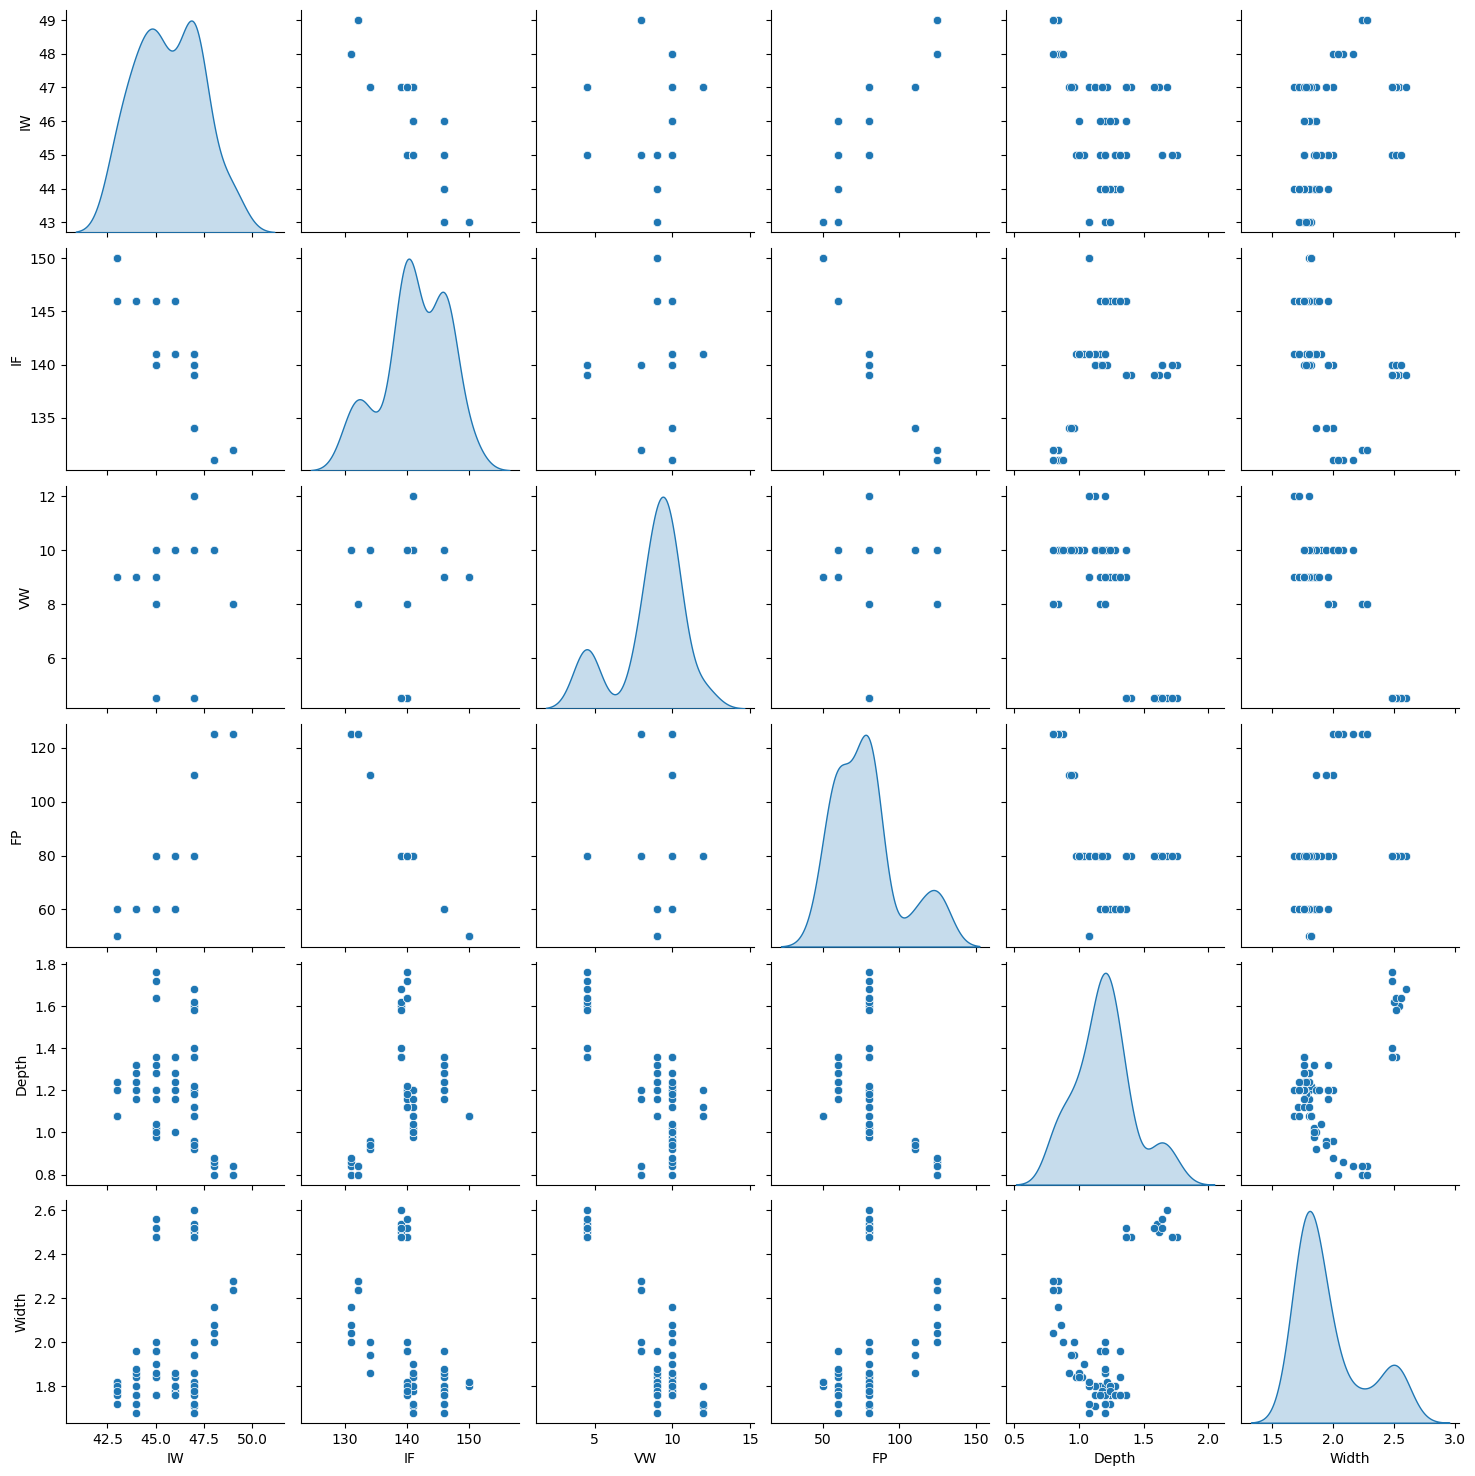

In [6]:
sns.pairplot(row_df.astype(float), diag_kind='kde')

Судя по графикам мы имеем дело с двумя раздельными категориями данных. Это видно как из распределений атрибутов (главная диагональ), так и из парных зависимостей Width от остальных атрибутов (Depth, IW, IF, FP). Единственный параметр имеющий возможную линейную зависимость с Width это Скорость сварки VW.

Для проверки гипотезы необходимо рассмотреть как регрессию саму по себе, так и регресию с предварительной кластеризацией.

**Проверим корреляцию**

In [7]:
row_df.corr()['Width']

IW       0.434869
IF      -0.510167
VW      -0.874257
FP       0.412962
Depth    0.425391
Width    1.000000
Name: Width, dtype: float64

Видно явную корреляцию с атрибутом - Скорость сварки VW. Что в принципе подтверждалось и графиком выше.

### Предобработка данных

**Нормализация**

In [117]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(row_df), columns = row_df.columns)
df_scaled.describe()

,IW,IF,VW,FP,Depth,Width
count,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01
mean,1.412450e-15,-1.862708e-15,-1.727014e-16,2.220446e-16,3.515706e-16,-6.784696e-17
std,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00
min,-1.600000e+00,-2.022217e+00,-2.022210e+00,-1.327477e+00,-1.769721e+00,-1.048075e+00
25%,-1.000000e+00,-4.566297e-01,-3.121533e-01,-8.589557e-01,-5.169972e-01,-7.593659e-01
50%,-1.000000e-01,-6.523281e-02,1.764345e-01,7.808688e-02,1.988451e-02,-4.706565e-01
75%,8.000000e-01,9.132593e-01,6.650222e-01,7.808688e-02,4.225458e-01,2.872057e-01
max,2.000000e+00,1.696053e+00,1.642198e+00,2.186433e+00,2.525333e+00,2.272083e+00


Теперь, как и писал ранее посмотрим кластеризацию данных. Учитывая, что данные имеют некоторую нелинейность, применим метод DBSCAN.

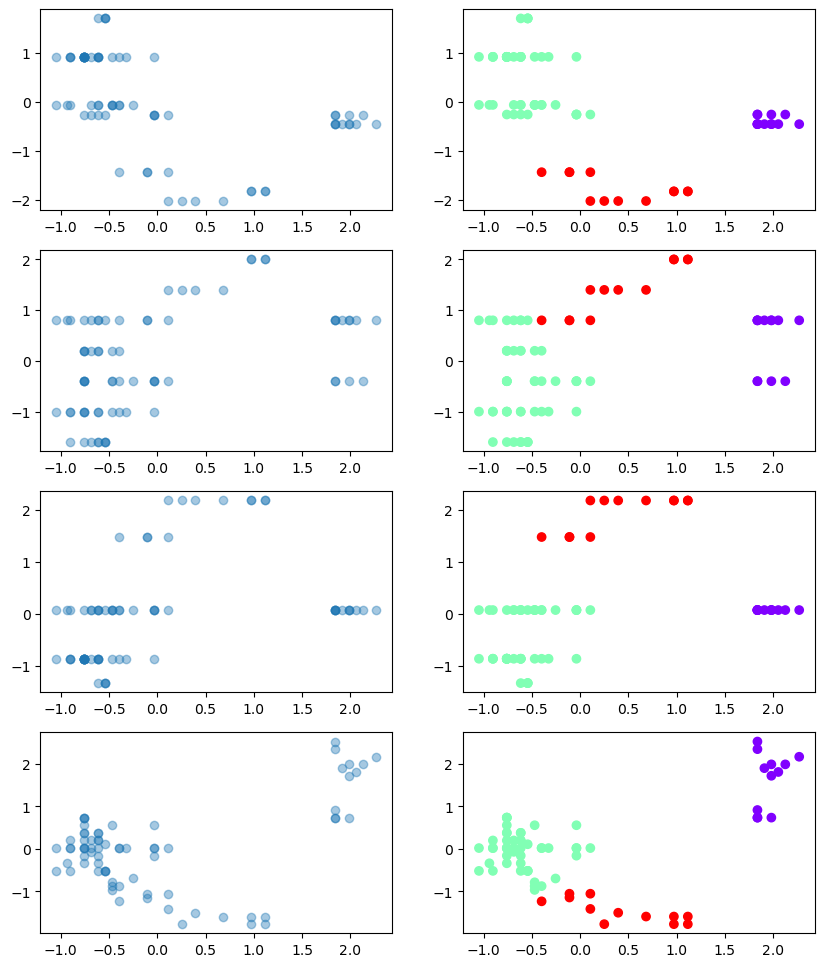

In [118]:
dbclaster = DBSCAN(eps = 2).fit(df_scaled)
#dblabels = K_means.labels_
# plot results
f, axes = plt.subplots(4, 2, figsize = (10, 12))

axes[0, 0].scatter(df_scaled['Width'], df_scaled['IF'], alpha = 0.4)
axes[0, 1].scatter(df_scaled['Width'], df_scaled['IF'], c = dbclaster.labels_, cmap = 'rainbow')
axes[1, 0].scatter(df_scaled['Width'], df_scaled['IW'], alpha = 0.4)
axes[1, 1].scatter(df_scaled['Width'], df_scaled['IW'], c = dbclaster.labels_, cmap = 'rainbow')
axes[2, 0].scatter(df_scaled['Width'], df_scaled['FP'], alpha = 0.4)
axes[2, 1].scatter(df_scaled['Width'], df_scaled['FP'], c = dbclaster.labels_, cmap = 'rainbow')
axes[3, 0].scatter(df_scaled['Width'], df_scaled['Depth'], alpha = 0.4)
axes[3, 1].scatter(df_scaled['Width'], df_scaled['Depth'], c = dbclaster.labels_, cmap = 'rainbow')
plt.show()


Как видно из графиков, метод разделил данные на 3 (три) класса.

Добавим в датасет дополнительный столбец в соответствии с присвоинным классом.

In [119]:
df_scaled['Class'] = dbclaster.labels_

Сделаем one-hot encoding

In [120]:
df_scaled = pd.get_dummies(df_scaled, columns = ['Class'], prefix = ['Class_'])

Проверим получившийся датасет

In [121]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IW        72 non-null     float64
 1   IF        72 non-null     float64
 2   VW        72 non-null     float64
 3   FP        72 non-null     float64
 4   Depth     72 non-null     float64
 5   Width     72 non-null     float64
 6   Class__0  72 non-null     bool   
 7   Class__1  72 non-null     bool   
 8   Class__2  72 non-null     bool   
dtypes: bool(3), float64(6)
memory usage: 3.7 KB


Что бы привести новые атрибуты в тот же формат, что и остальные применим снова StandardScaler

In [127]:
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns = df_scaled.columns)
df_scaled.describe()

,IW,IF,VW,FP,Depth,Width,Class__0,Class__1,Class__2
count,72.000000,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,72.000000,7.200000e+01,7.200000e+01,7.200000e+01
mean,0.000000,-7.401487e-17,-1.233581e-17,-1.233581e-17,-1.850372e-17,0.000000,6.167906e-17,2.467162e-17,2.467162e-17
std,1.007018,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018,1.007018e+00,1.007018e+00,1.007018e+00
min,-1.600000,-2.022217e+00,-2.022210e+00,-1.327477e+00,-1.769721e+00,-1.048075,-4.472136e-01,-1.414214e+00,-4.472136e-01
25%,-1.000000,-4.566297e-01,-3.121533e-01,-8.589557e-01,-5.169972e-01,-0.759366,-4.472136e-01,-1.414214e+00,-4.472136e-01
50%,-0.100000,-6.523281e-02,1.764345e-01,7.808688e-02,1.988451e-02,-0.470656,-4.472136e-01,7.071068e-01,-4.472136e-01
75%,0.800000,9.132593e-01,6.650222e-01,7.808688e-02,4.225458e-01,0.287206,-4.472136e-01,7.071068e-01,-4.472136e-01
max,2.000000,1.696053e+00,1.642198e+00,2.186433e+00,2.525333e+00,2.272083,2.236068e+00,7.071068e-01,2.236068e+00


Видно, что "старые" атрибуты не изменились (аналогичны после первой нормализации), а новые номализовались.

Теперь у нас все готово для моделирования.

### Обучение моделей ML

In [135]:
X = df_scaled.copy()
y = X.pop('Width')
Xc = X.drop(['Class__0', 'Class__1', 'Class__2'], axis = 1)

In [138]:
y

0     2.055551
1     1.911196
2     2.272083
3     1.983373
4     1.839019
        ...   
67   -0.903721
68   -0.759366
69   -0.759366
70   -0.759366
71   -0.759366
Name: Width, Length: 72, dtype: float64

### Сравнение и выбор моделей ML

### Сохранение модели